# Fancy Indexing

The previous chapters discussed how to access and modify portions of arrays using simple indices (e.g., `arr[0]`), slices (e.g., `arr[:5]`), and Boolean masks (e.g., `arr[arr > 0]`).
In this chapter, we'll look at another style of array indexing, known as *fancy* or *vectorized* indexing, in which we pass arrays of indices in place of single scalars.
This allows us to very quickly access and modify complicated subsets of an array's values.

## Exploring Fancy Indexing

Fancy indexing is conceptually simple: it means passing an array of indices to access multiple array elements at once.
For example, consider the following array:

In [1]:
import numpy as np
rng = np.random.default_rng(seed=1701)

x = rng.integers(100, size=10)
print(x)

[90 40  9 30 80 67 39 15 33 79]


Suppose we want to access three different elements. We could do it like this:

In [2]:
[x[3], x[7], x[2]]

[30, 15, 9]

Alternatively, we can pass a single list or array of indices to obtain the same result:

In [3]:
ind = [3, 7, 4]
x[ind]

array([30, 15, 80])

When using arrays of indices, the shape of the result reflects the shape of the *index arrays* rather than the shape of the *array being indexed*:

In [4]:
ind = np.array([[3, 7],
                [4, 5]])
x[ind]

array([[30, 15],
       [80, 67]])

Fancy indexing also works in multiple dimensions. Consider the following array:

In [5]:
X = np.arange(12).reshape((3, 4))
X

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

Like with standard indexing, the first index refers to the row, and the second to the column:

In [6]:
row = np.array([0, 1, 2])
col = np.array([2, 1, 3])
X[row, col]

array([ 2,  5, 11])

Notice that the first value in the result is `X[0, 2]`, the second is `X[1, 1]`, and the third is `X[2, 3]`.
The pairing of indices in fancy indexing follows all the broadcasting rules that were mentioned in [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb).
So, for example, if we combine a column vector and a row vector within the indices, we get a two-dimensional result:

In [7]:
X[row[:, np.newaxis], col]

array([[ 2,  1,  3],
       [ 6,  5,  7],
       [10,  9, 11]])

Here, each row value is matched with each column vector, exactly as we saw in broadcasting of arithmetic operations.
For example:

In [8]:
row[:, np.newaxis] * col

array([[0, 0, 0],
       [2, 1, 3],
       [4, 2, 6]])

It is always important to remember with fancy indexing that the return value reflects the *broadcasted shape of the indices*, rather than the shape of the array being indexed.

## Combined Indexing

For even more powerful operations, fancy indexing can be combined with the other indexing schemes we've seen. For example, given the array `X`:

In [9]:
print(X)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


We can combine fancy and simple indices:

In [10]:
X[2, [2, 0, 1]]

array([10,  8,  9])

We can also combine fancy indexing with slicing:

In [11]:
X[1:, [2, 0, 1]]

array([[ 6,  4,  5],
       [10,  8,  9]])

And we can combine fancy indexing with masking:

In [12]:
mask = np.array([True, False, True, False])
X[row[:, np.newaxis], mask]

array([[ 0,  2],
       [ 4,  6],
       [ 8, 10]])

All of these indexing options combined lead to a very flexible set of operations for efficiently accessing and modifying array values.

## Example: Selecting Random Points

One common use of fancy indexing is the selection of subsets of rows from a matrix.
For example, we might have an $N$ by $D$ matrix representing $N$ points in $D$ dimensions, such as the following points drawn from a two-dimensional normal distribution:

In [13]:
mean = [0, 0]
cov = [[1, 2],
       [2, 5]]
X = rng.multivariate_normal(mean, cov, 100)
X.shape

(100, 2)

Using the plotting tools we will discuss in [Introduction to Matplotlib](04.00-Introduction-To-Matplotlib.ipynb), we can visualize these points as a scatter plot (see the following figure):

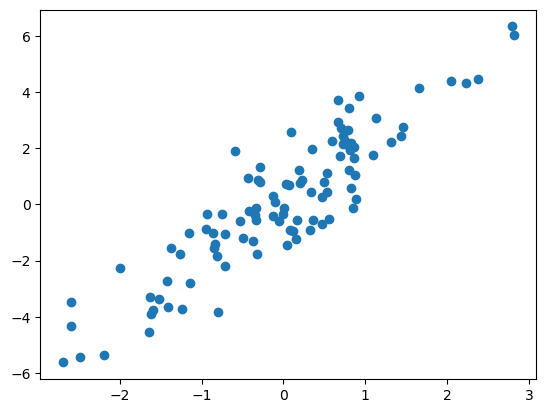

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1]);

Let's use fancy indexing to select 20 random points. We'll do this by first choosing 20 random indices with no repeats, and using these indices to select a portion of the original array:

In [16]:
indices = np.random.choice(X.shape[0], 20, replace=False)
indices

array([86, 29, 25, 16, 38, 99, 21, 53, 72, 92, 66,  4, 67,  1, 50, 74, 93,
       81, 75, 73])

In [17]:
selection = X[indices]  # fancy indexing here
selection.shape

(20, 2)

Now to see which points were selected, let's overplot large circles at the locations of the selected points (see the following figure):

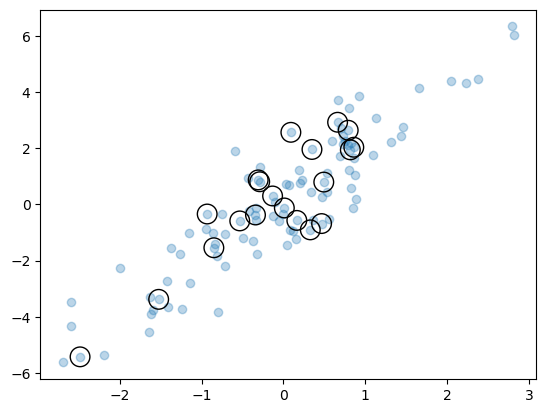

In [18]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.3)
plt.scatter(selection[:, 0], selection[:, 1],
            facecolor='none', edgecolor='black', s=200);

This sort of strategy is often used to quickly partition datasets, as is often needed in train/test splitting for validation of statistical models (see [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)), and in sampling approaches to answering statistical questions.

## Modifying Values with Fancy Indexing

Just as fancy indexing can be used to access parts of an array, it can also be used to modify parts of an array.
For example, imagine we have an array of indices and we'd like to set the corresponding items in an array to some value:

In [19]:
x = np.arange(10)
i = np.array([2, 1, 8, 4])
x[i] = 99
print(x)

[ 0 99 99  3 99  5  6  7 99  9]


We can use any assignment-type operator for this. For example:

In [20]:
x[i] -= 10
print(x)

[ 0 89 89  3 89  5  6  7 89  9]


Notice, though, that repeated indices with these operations can cause some potentially unexpected results. Consider the following:

In [21]:
x = np.zeros(10)
x[[0, 0]] = [4, 6]
print(x)

[6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Where did the 4 go? This operation first assigns `x[0] = 4`, followed by `x[0] = 6`.
The result, of course, is that `x[0]` contains the value 6.

Fair enough, but consider this operation:

In [22]:
i = [2, 3, 3, 4, 4, 4]
x[i] += 1
x

array([6., 0., 1., 1., 1., 0., 0., 0., 0., 0.])

You might expect that `x[3]` would contain the value 2 and `x[4]` would contain the value 3, as this is how many times each index is repeated. Why is this not the case?
Conceptually, this is because `x[i] += 1` is meant as a shorthand of `x[i] = x[i] + 1`. `x[i] + 1` is evaluated, and then the result is assigned to the indices in `x`.
With this in mind, it is not the augmentation that happens multiple times, but the assignment, which leads to the rather nonintuitive results.

So what if you want the other behavior where the operation is repeated? For this, you can use the `at` method of ufuncs and do the following:

In [23]:
x = np.zeros(10)
np.add.at(x, i, 1)
print(x)

[0. 0. 1. 2. 3. 0. 0. 0. 0. 0.]


The `at` method does an in-place application of the given operator at the specified indices (here, `i`) with the specified value (here, 1).
Another method that is similar in spirit is the `reduceat` method of ufuncs, which you can read about in the [NumPy documentation](https://numpy.org/doc/stable/reference/ufuncs.html).

## Example: Binning Data

You could use these ideas to efficiently do custom binned computations on data.
For example, imagine we have 100 values and would like to quickly find where they fall within an array of bins.
We could compute this using `ufunc.at` like this:

In [24]:
rng = np.random.default_rng(seed=1701)
x = rng.normal(size=100)

# compute a histogram by hand
bins = np.linspace(-5, 5, 20)
counts = np.zeros_like(bins)

# find the appropriate bin for each x
i = np.searchsorted(bins, x)

# add 1 to each of these bins
np.add.at(counts, i, 1)

The counts now reflect the number of points within each bin—in other words, a histogram (see the following figure):

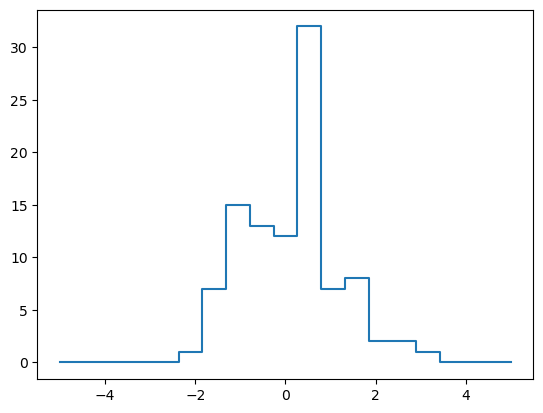

In [25]:
# plot the results
plt.plot(bins, counts, drawstyle='steps');

Of course, it would be inconvenient to have to do this each time you want to plot a histogram.
This is why Matplotlib provides the `plt.hist` routine, which does the same in a single line:

```python
plt.hist(x, bins, histtype='step');
```

This function will create a nearly identical plot to the one just shown.
To compute the binning, Matplotlib uses the `np.histogram` function, which does a very similar computation to what we did before. Let's compare the two here:

In [26]:
print(f"NumPy histogram ({len(x)} points):")
%timeit counts, edges = np.histogram(x, bins)

print(f"Custom histogram ({len(x)} points):")
%timeit np.add.at(counts, np.searchsorted(bins, x), 1)

NumPy histogram (100 points):
30.4 μs ± 1.07 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Custom histogram (100 points):
20.8 μs ± 671 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Our own one-line algorithm is twice as fast as the optimized algorithm in NumPy! How can this be? If you dig into the `np.histogram` source code (you can do this in IPython by typing `np.histogram??`), you'll see that it's quite a bit more involved than the simple search-and-count that we've done; this is because NumPy's algorithm is more flexible, and particularly is designed for better performance when the number of data points becomes large:

In [27]:
x = rng.normal(size=1000000)
print(f"NumPy histogram ({len(x)} points):")
%timeit counts, edges = np.histogram(x, bins)

print(f"Custom histogram ({len(x)} points):")
%timeit np.add.at(counts, np.searchsorted(bins, x), 1)

NumPy histogram (1000000 points):
125 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Custom histogram (1000000 points):
152 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


What this comparison shows is that algorithmic efficiency is almost never a simple question. An algorithm efficient for large datasets will not always be the best choice for small datasets, and vice versa (see [Big-O Notation](02.08-Sorting.ipynb#Big-O-Notation)).
But the advantage of coding this algorithm yourself is that with an understanding of these basic methods, the sky is the limit: you're no longer constrained to built-in routines, but can create your own approaches to exploring the data.
Key to efficiently using Python in data-intensive applications is not only knowing about general convenience routines like `np.histogram` and when they're appropriate, but also knowing how to make use of lower-level functionality when you need more pointed behavior.